In [82]:
import re
import pandas as pd

pattern = re.compile(
    r'BenchmarkSort/([^-]+)-(\d+)-(\d+)\s+(\d+)\s+([\d.]+)\s+(ns/op|µs/op|ms/op)'
)

results = []

with open("results.txt", "r") as fp:
    log = fp.read()

for match in pattern.finditer(log):
    algorithm, input_size, threads, iterations, time, unit = match.groups()
    results.append({
        "algorithm": algorithm,
        "input_size": int(input_size),
        "threads": int(threads),
        "iterations": int(iterations),
        "time_per_op": float(time),
        "unit": unit
    })

df = pd.DataFrame(results)
print(df)

         algorithm  input_size  threads  iterations   time_per_op   unit
0   insertion_sort           8        8    72939306  1.655000e+01  ns/op
1   insertion_sort          16        8    35361025  3.314000e+01  ns/op
2   insertion_sort          32        8    18674656  6.602000e+01  ns/op
3   insertion_sort          64        8     7690414  1.670000e+02  ns/op
4   insertion_sort         128        8     3559381  3.862000e+02  ns/op
5   insertion_sort         256        8     1289980  1.204000e+03  ns/op
6   insertion_sort         512        8      712992  1.671000e+03  ns/op
7   insertion_sort        1024        8      428809  2.794000e+03  ns/op
8   insertion_sort        2048        8      230858  5.102000e+03  ns/op
9   insertion_sort        4096        8      123912  9.727000e+03  ns/op
10  insertion_sort        8192        8       64597  1.865700e+04  ns/op
11  insertion_sort       16384        8       33128  3.624200e+04  ns/op
12  insertion_sort       32768        8       14496

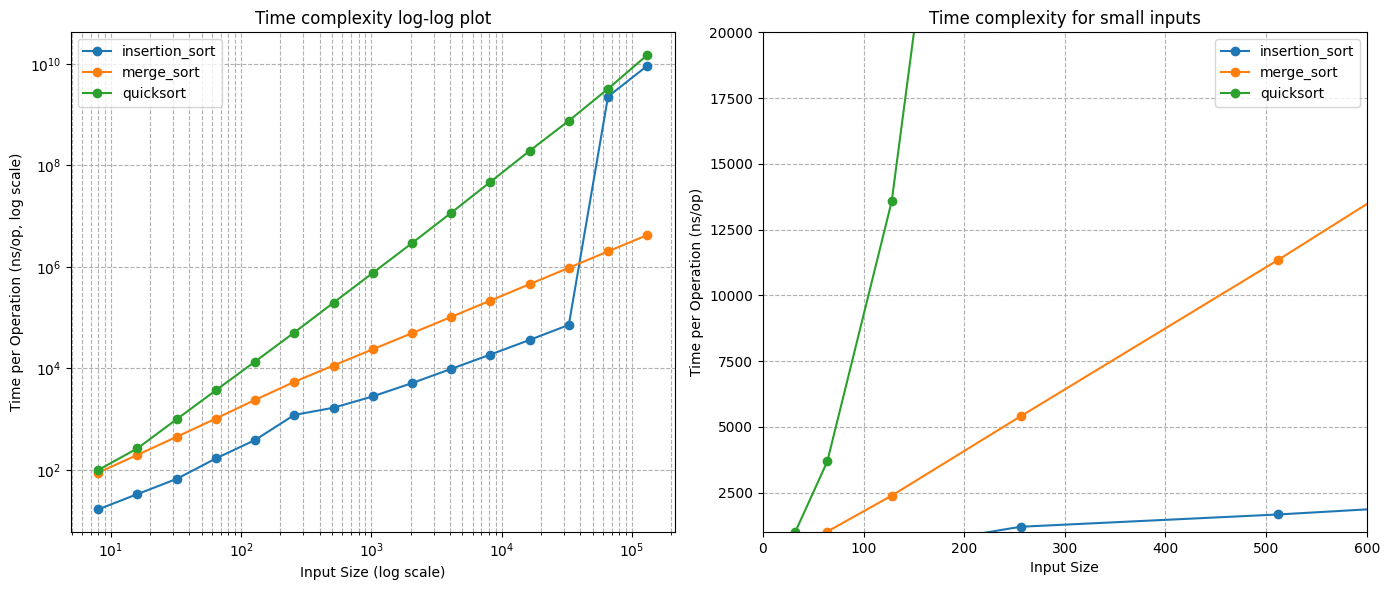

In [83]:
import matplotlib.pyplot as plt

groups = df.groupby('algorithm')

plt.figure(figsize=(14, 6))

# Log-log plot
plt.subplot(1, 2, 1)
for name, group in groups:
    plt.plot(group['input_size'], group['time_per_op'], marker='o', linestyle='-', label=name)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Input Size (log scale)')
plt.ylabel('Time per Operation (ns/op, log scale)')
plt.title('Time complexity log-log plot')
plt.legend()
plt.grid(True, which="both", ls="--")

# Linear plot of small input sizes
plt.subplot(1, 2, 2)
for name, group in groups:
    plt.plot(group['input_size'], group['time_per_op'], marker='o', linestyle='-', label=name)
plt.xlabel('Input Size')
plt.ylabel('Time per Operation (ns/op)')
plt.xlim(0, 600)
plt.ylim(1e3, 2e4)
plt.title('Time complexity for small inputs')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Independent and dependent variables
x = df["input_size"].values
y = df["time_per_op"].values

# Define possible complexity functions
def linear(n, a, b): return a * n + b
def nlogn(n, a, b): return a * n * np.log(n) + b
def quadratic(n, a, b): return a * n**2 + b
def cubic(n, a, b): return a * n**3 + b

# Fit each model
models = {
    "Linear": linear,
    "n log n": nlogn,
    "Quadratic": quadratic,
    "Cubic": cubic
}
results = []

for algo, group in df.groupby("algorithm"):
    x = group["input_size"].values
    y = group["time_per_op"].values

    for name, func in models.items():
        try:
            popt, _ = curve_fit(func, x, y, maxfev=10000)
            y_pred = func(x, *popt)
            mse = np.mean((y - y_pred)**2)
            results.append({
                "Algorithm": algo,
                "Model": name,
                "Mean Squared Error": mse
            })
        except RuntimeError:
            results.append({
                "Algorithm": algo,
                "Model": name,
                "Mean Squared Error": np.inf  # Could not fit
            })

# Create and print the error DataFrame
error_df = pd.DataFrame(results).sort_values(["Algorithm", "Mean Squared Error"])
print(error_df.to_string(index=False))

     Algorithm     Model  Mean Squared Error
insertion_sort Quadratic        2.063240e+16
insertion_sort     Cubic        8.176884e+16
insertion_sort   n log n        4.358333e+17
insertion_sort    Linear        5.503322e+17
    merge_sort   n log n        8.101973e+07
    merge_sort    Linear        1.150348e+09
    merge_sort Quadratic        8.028107e+10
    merge_sort     Cubic        1.710453e+11
     quicksort Quadratic        1.643336e+16
     quicksort     Cubic        1.244469e+17
     quicksort   n log n        1.072473e+18
     quicksort    Linear        1.356365e+18


ValueError: x and y must have same first dimension, but have shapes (15,) and (20,)

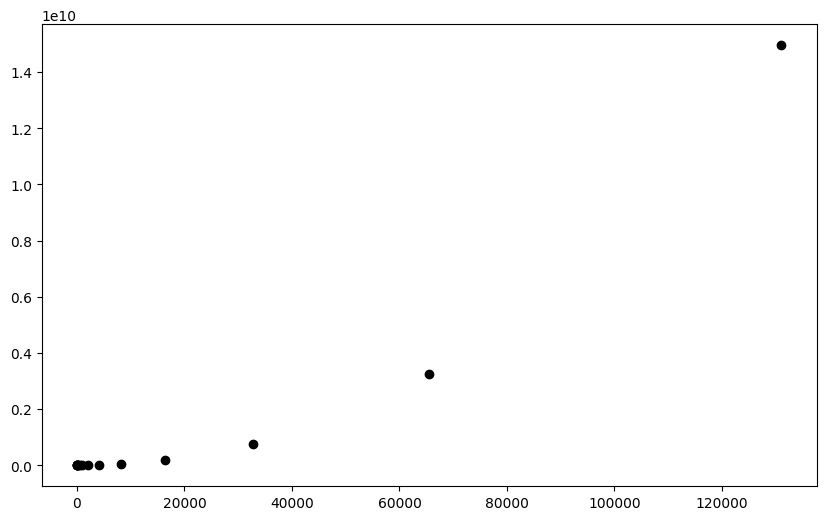

In [85]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="Actual", color="black")

colors = ["red", "green", "blue", "purple"]
for (name, (popt, y_pred)), color in zip(fits.items(), colors):
    plt.plot(x, y_pred, label=f"{name} fit", color=color)

plt.title("Curve fitting of insertion_sort time complexity")
plt.xlabel("Input Size")
plt.ylabel("Time per Operation (ns)")
plt.legend()
plt.grid(True)
plt.show()